In [1]:
using CSV
using DataFrames
using JuMP
using Plots
using Random
using Statistics
using LinearAlgebra
using Distributions
using BipartiteMatching
using Gurobi
using LinearAlgebra
using SymPy
using NLsolve
using LaTeXStrings


# Proof of Proposition 3 (i)

In [2]:
@vars delta alphaf alpha x1_lb x2_lb x1_ub x2_ub
ub_concave_sod = (-2*(x1_lb+x2_lb)*((x1_lb*x2_lb)*(max(alphaf-alpha-delta,0))^2)^2 -16*(x1_lb+x2_lb)*(x1_lb*x2_lb)*alphaf*alpha 
    + 8*(alphaf+delta)^2 *(x1_ub*x2_ub^2+4*x1_ub^3)+ 8*(alpha+delta)^2 *(x1_ub^2*x2_ub+4*x2_ub^3)
    -24*alphaf^2*x1_lb^2*x2_lb-24*alpha^2*x1_lb*x2_lb^2
    )/(-(x1_ub*x2_ub*(alphaf-alpha + delta)^2)^2 + 8*(alphaf+alpha)^2*x1_lb*x2_lb +16*alpha^2 *x2_lb^2+16*alphaf^2 *x1_lb^2-16)

# Define a Julia function for the equation to solve x1
function equation_x1!(F, x, alphaf_val, alpha_val)
    F[1] = exp(-0.5*(alphaf_val + alpha_val)*x[1] + 2*alpha_val*(log(x[1]) + alphaf_val*x[1])/(alphaf_val + alpha_val)) + 2*(log(x[1]) + alphaf_val*x[1])/(alphaf_val + alpha_val)
end

# Define a Julia function to evaluate sol_f_perturbed
tolerance = 1e-5
function sol_f_func2(alphaf_val, alpha_val, delta_val)
    x1_sol = nlsolve((F, x) -> equation_x1!(F, x, alphaf_val, alpha_val), [0.2], autodiff=:forward, ftol=tolerance).zero[1]
    x1_sol_ub, x1_sol_lb = x1_sol+tolerance, x1_sol-tolerance
    x2_sol_ub, x2_sol_lb = -2*(log(x1_sol_lb) + alphaf_val*x1_sol_lb)/(alphaf_val + alpha_val), -2*(log(x1_sol_ub) + alphaf_val*x1_sol_ub)/(alphaf_val + alpha_val)
    ub_concave_sod_val = subs(ub_concave_sod, (alphaf, alphaf_val), (alpha, alpha_val), 
        (x1_lb, x1_sol_lb*(1-2*delta)), (x2_lb, x2_sol_lb*(1-2*delta)), 
        (x1_ub, x1_sol_ub), (x2_ub, x2_sol_ub), (delta,delta_val))
    return ub_concave_sod_val < 0
end

sol_f_func2 (generic function with 1 method)

In [3]:
function calculate_ub_concave_sod_matrix(delta_val)

    # Adjust the upper limit as needed
    alphaf_range, alpha_range = 0.0:delta_val:exp(1), 0.0:delta_val:exp(1)/2
    alphaf_range, alpha_range = collect(alphaf_range), collect(alpha_range)
    alphaf_range[1] = 0.0001
    alpha_range[1] = 0.0001
    results_matrix = Matrix{Int}(undef, length(alphaf_range), length(alpha_range))

    for (i, alphaf_val) in enumerate(alphaf_range)
        print(alphaf_val, '\n')
        for (j, alpha_val) in enumerate(alpha_range)
            if alpha_val <= min(alphaf_val, exp(1) - alphaf_val)
                results_matrix[i, j] = sol_f_func2(alphaf_val, alpha_val, delta_val)
            else
                results_matrix[i, j] = -1  # Assign -1 when the condition is not satisfied
            end
        end
    end

    return results_matrix
end


calculate_ub_concave_sod_matrix (generic function with 1 method)

In [ ]:
# delta = 0.01: 15 min
delta_val = 0.01
results_matrix = calculate_ub_concave_sod_matrix(delta_val)
CSV.write("concave01.csv", DataFrame(results_matrix, :auto), writeheader=false)

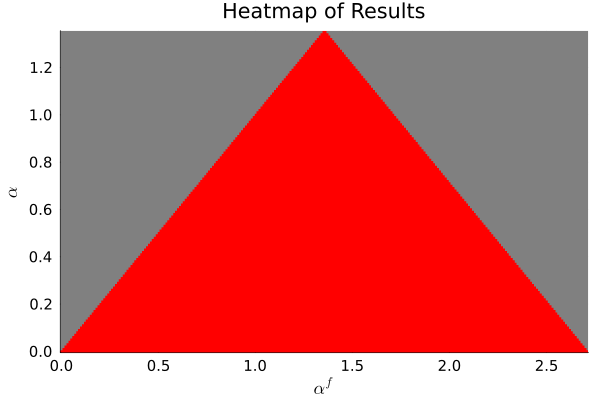

In [25]:
loaded_dataframe = CSV.File("concave01.csv", header=false) |> DataFrame
loaded_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(0.0:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)


# Proof of Proposition 3 (ii)

In [7]:
@vars delta alphaf alpha x1_lb x2_lb x1_ub x2_ub
lb_convex_sod = (-(alphaf-alpha+delta)^2 *4*x1_ub*x2_ub*(x1_ub+x2_ub)+16*max(0,x2_lb-x1_ub)*alphaf*x1_lb-16*(x2_ub-x1_lb)*(alpha+delta)*x2_ub
    )/(-(max(alphaf-alpha-delta,0))^2 *x1_lb*x2_lb + 4*(1-alpha*x2_lb-alphaf*x1_lb))

# Define a Julia function for the equation to solve x1
function equation_x1!(F, x, alphaf_val, alpha_val)
    F[1] = exp(-0.5*(alphaf_val + alpha_val)*x[1] + 2*alpha_val*(log(x[1]) + alphaf_val*x[1])/(alphaf_val + alpha_val)) + 2*(log(x[1]) + alphaf_val*x[1])/(alphaf_val + alpha_val)
end

# Define a Julia function to evaluate sol_f_perturbed
tolerance = 1e-5
function sol_f_func(alphaf_val, alpha_val, delta_val)
    x1_sol = nlsolve((F, x) -> equation_x1!(F, x, alphaf_val, alpha_val), [0.2], autodiff=:forward, ftol=tolerance).zero[1]
    x1_sol_ub, x1_sol_lb = x1_sol+tolerance, x1_sol-tolerance
    x2_sol_ub, x2_sol_lb = -2*(log(x1_sol_lb) + alphaf_val*x1_sol_lb)/(alphaf_val + alpha_val), -2*(log(x1_sol_ub) + alphaf_val*x1_sol_ub)/(alphaf_val + alpha_val)
    lb_convex_sod_val = subs(lb_convex_sod, (alphaf, alphaf_val), (alpha, alpha_val), 
        (x1_lb, x1_sol_lb*(1-2*delta)), (x2_lb, x2_sol_lb*(1-2*delta)), 
        (x1_ub, x1_sol_ub), (x2_ub, x2_sol_ub),(delta,delta_val))
    return lb_convex_sod_val > 0
end

sol_f_func (generic function with 1 method)

In [8]:
function calculate_lb_convex_sod_matrix(delta_val)

    # Adjust the upper limit as needed
    alphaf_range = delta_val:delta_val:exp(1)
    alpha_range = 0.0:delta_val:exp(1)/2
    results_matrix = Matrix{Int}(undef, length(alphaf_range), length(alpha_range))

    for (i, alphaf_val) in enumerate(alphaf_range)
        print(alphaf_val, '\n')
        for (j, alpha_val) in enumerate(alpha_range)
            if alpha_val <= min(alphaf_val, exp(1) - alphaf_val)
                results_matrix[i, j] = sol_f_func(alphaf_val, alpha_val, delta_val)
            else
                results_matrix[i, j] = -1  # Assign -1 when the condition is not satisfied
            end
        end
    end
    
    return results_matrix

end


calculate_lb_convex_sod_matrix (generic function with 1 method)

In [ ]:
# delta = 0.01: 15 min
delta_val = 0.01
results_matrix = calculate_lb_convex_sod_matrix(delta_val)
CSV.write("convex01.csv", DataFrame(results_matrix, :auto), writeheader=false)

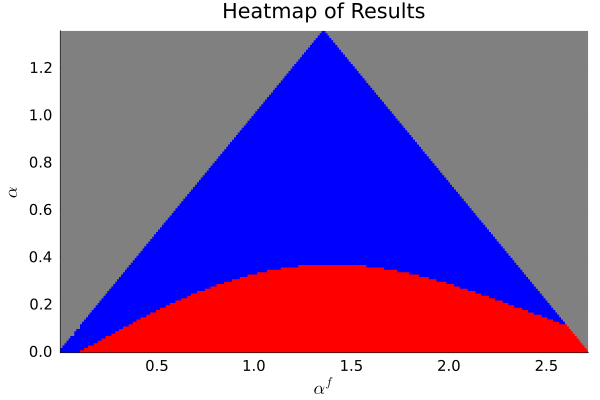

In [9]:
loaded_dataframe = CSV.File("convex01.csv", header=false) |> DataFrame
loaded_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(delta_val:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)


In [ ]:
# delta = 0.005: 60 min
delta_val = 0.005
results_matrix = calculate_lb_convex_sod_matrix(delta_val)
CSV.write("convex005.csv", DataFrame(results_matrix, :auto), writeheader=false)

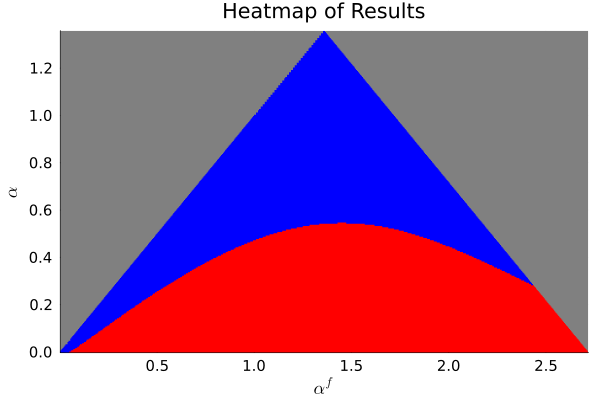

In [27]:
loaded_dataframe = CSV.File("convex005.csv", header=false) |> DataFrame
loaded_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(delta_val:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)


In [ ]:
# delta = 0.0025: 4 hours
delta_val = 0.0025
results_matrix = calculate_lb_convex_sod_matrix(delta_val)
CSV.write("convex0025.csv", DataFrame(results_matrix, :auto), writeheader=false)

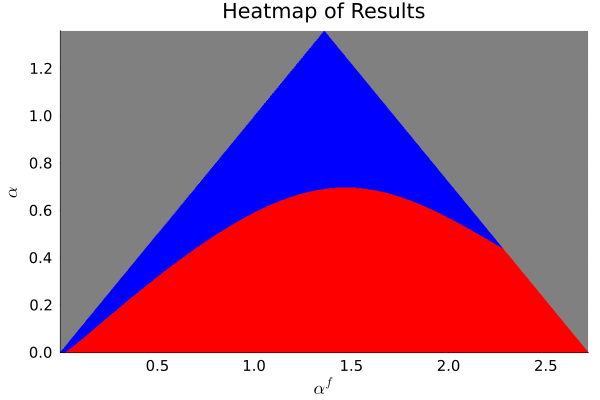

In [29]:
loaded_dataframe = CSV.File("convex0025.csv", header=false) |> DataFrame
loaded_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(delta_val:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)


In [ ]:
# delta = 0.001: 20 hours
delta_val = 0.001
results_matrix = calculate_lb_convex_sod_matrix(delta_val)
CSV.write("convex001.csv", DataFrame(results_matrix, :auto), writeheader=false)

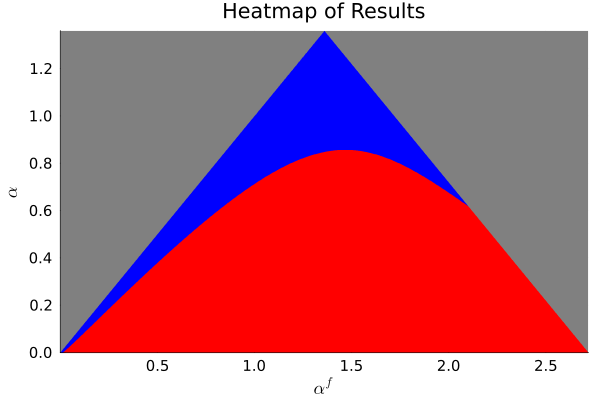

In [10]:
loaded_dataframe = CSV.File("convex001.csv", header=false) |> DataFrame
loaded_matrix = Matrix(loaded_dataframe)

# Create a heatmap to visualize the results
color_palette = cgrad([:gray, :blue, :red], categorical=true)

heatmap(delta_val:delta_val:exp(1), 0.0:delta_val:exp(1)/2, transpose(results_matrix), color=:auto, colormap=color_palette, colorbar=false, title="Heatmap of Results",
        xlabel=L"$\alpha^f$", ylabel=L"$\alpha$", tickfont=font(10), guidefontsize=12)
